# Project One

## Introduction

In this assignment I will be exploring Airbnb rental price data in New York City. Specifically, I am interest in answering, 
"How does the room type and location of an Airbnb listing affect it's price, in New York City?"

The data set I will be working with is from Inside Airbnb, retrieved from http://insideairbnb.com/index.html.

To be more specific my response variable(Y) will the price in dollars per night of an New York City Airbnb.

My first explanatory variable(X1) will the type of room the listing is for, I will investigate the types later on in the assignment.

My second explanatory variable(X2) will be the the location of the listing. I will be using the neighourhood of New York City the listing is in to classify location.

In the data room_type is the room type of the listing and neighbourhood_group is the neighbourhood of New York City the listing is located in.


In [ ]:
# Uncomment following line to install on colab
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes pygeos rtree

ERROR: Operation cancelled by user


In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from google.colab import files

import geopandas as gpd

from shapely.geometry import Point

import matplotlib.cm as cm
from matplotlib.colors import Normalize 

%matplotlib inline

In [ ]:
# read the data in using pandas
data_raw=pd.read_csv('AB_NYC_2019.csv')

data_raw = pd.DataFrame(data_raw)

# let's take a look at the top 5 rows of our raw data set
data_raw.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Cleaning Data

In [ ]:
# Let's take create a subset of the dataframe to only include the columns we will need

data = data_raw[["id", "price", "room_type", 'neighbourhood_group']]
data.head()

# Below we can see that our new data only has the 4 columns we need.

,id,price,room_type,neighbourhood_group
0,2539,149,Private room,Brooklyn
1,2595,225,Entire home/apt,Manhattan
2,3647,150,Private room,Manhattan
3,3831,89,Entire home/apt,Brooklyn
4,5022,80,Entire home/apt,Manhattan


In [ ]:
# taking a look at the types of our data
data.dtypes

id                      int64
price                   int64
room_type              object
neighbourhood_group    object
dtype: object

We see that id, price are numerical data while room_type and neighbourhood_group are categorical data

In [ ]:
# Clean our data by droping rows with a nans in any of the columns
print("There are {} missing values in the data set".format(data_raw.isnull().values.sum()))

data_no_na = data.dropna(axis=0, how='any')

There are 20141 missing values in the data set


## Summary Statistics

In [ ]:
# Lets pull up the summary statistics of our data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.0,9471945.0,19677284.0,29152178.5,36487245.0
price,48895.0,1.527207e+02,2.401542e+02,0.0,69.0,106.0,175.0,10000.0


First we can see that we have 48895 observations in the data set. We see that the mean price of Airbnb listing is for 152 dollars per night. The standard deviation of prices is 240. Interestingly, the cheapest listing is for 0 a night, which may be human error, and the most expensive listing is for 10000 dollars a night. We are also given the 25%, 50% and 75% percentiles.

We can ignore the id as the values are meaningless and is only used for identification.

In [ ]:
# Unique values for room_type and neighbour_hood group

print("There are {} unique room_types in the data which are are: {}".format(data['room_type'].nunique() ,data['room_type'].unique()))
print("There are {} unique neighbourhood_groups in the data which are: {} ".format(data['neighbourhood_group'].nunique(), data['neighbourhood_group'].unique()))

There are 3 unique room_types in the data which are are: ['Private room' 'Entire home/apt' 'Shared room']
There are 5 unique neighbourhood_groups in the data which are: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx'] 


We can see that there are 3 unique room types in the data which are 'Private room,' 'Entire home/apt' and 'Shared room'. 
Entire home/apt means that the entire unit is listed, whether it was a home or apartment.

There are 5 unique New York City neighbourhoods in our data which are; 'Brooklyn', 'Manhattan','Queens', 'Staten Island' and 'Bronx'.

## Histogram of Price, Room type and Neighbourhood

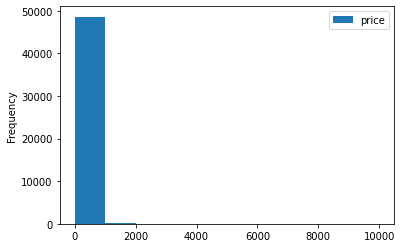

In [ ]:
data[['price']].plot(kind='hist')

We can see that the majority of listings fall below 1000 dollars per night price. There seems to be a few listing between 1000 
and 2000 dollars a night and very few listings over the price of 2000 per night.

Text(0, 0.5, 'Frequency')

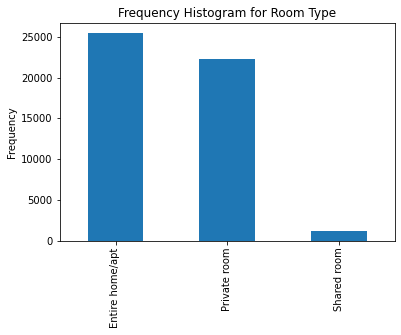

In [ ]:
data['room_type'].value_counts().plot(kind='bar')
plt.title("Frequency Histogram for Room Type")
plt.ylabel("Frequency")

From the histogram above, we note that most listings in New York City is for the entire home/apartment. The second most popular listed room type are private rooms and the least popular, by far, are shared rooms. This suggests that many hosts understand the value of privacy for customers.

Text(0, 0.5, 'Frequency')

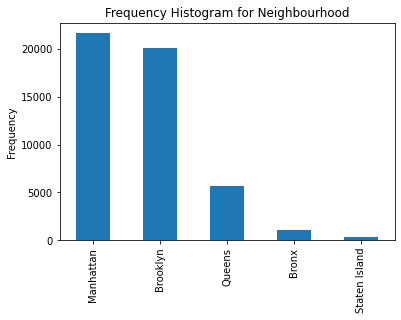

In [ ]:
data['neighbourhood_group'].value_counts().plot(kind='bar')
plt.title("Frequency Histogram for Neighbourhood")
plt.ylabel("Frequency")

From the histogram above, we can see the number of listings in each neighbourhood in New York City. In descending order; Manhattan, Brooklyn, Queens, Bronx and Staten Island. The majority of listings are found in either Manhattan and Brooklyn, this may suggest that Manhattan and Brooklyn are popular tourist destinations which high demand for AirBnbs. 

## Visualizing Price to Room Type and Price to Neighbourhood

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

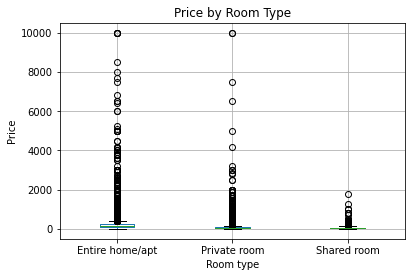

In [ ]:
# Since room_type is a categorical data, lets creates a boxplot to take a look
# at how price differs by room_type

data.boxplot(column = 'price', by = "room_type")
plt.xlabel("Room type")
plt.ylabel("Price")
plt.title("Price by Room Type")
plt.suptitle("")

In the plot above, we can see how price differs by room type. There seems to be a larger variation in prices for listings of the entire home/apartment and private room type compared to shared rooms which are all under 2000 dollars a night. There are more expensive listings for the entire home/apartment compared to private rooms. This make sense as we expect consumers are willing to pay more for more privacy and a larger space. For all three room types, the majority of the room prices are far below 2000.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

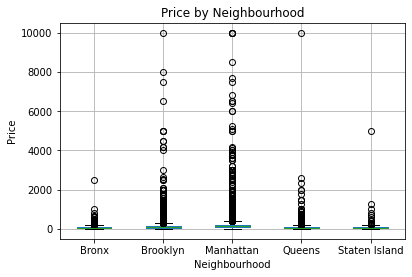

In [ ]:
data.boxplot(column = 'price', by = "neighbourhood_group")
plt.xlabel("Neighbourhood")
plt.ylabel("Price")
plt.title("Price by Neighbourhood")
plt.suptitle("")

In the plot above, we can see how price differs between the neighbourhoods of New York City. The majority of listings in the Bronx, Queens and Staten Island fall below 2000, which a few exceptions. Although the majority of listings are similar across all neighourhoods, Brooklyn and Manhattan have a number of listings over 2000 dollar listing price.  As we saw before, Brooklyn and Manhattan were the most popular in terms of listings, so it may not come as a surprise that there are out outliers in Brooklyn and Manhattan.

## Summary

In first project, I found interesting results on how pricing of a Airbnbs listing is affected why its room type and its neighbourhood in New York City. We found that there is a larger variation in prices for Airbnb listings of entire homes/apartments and private rooms compared to shared rooms. I also discovered that we see an greater variation in prices for listings in Brooklyn and Manhattan compared to listings in Bronx, Queens and Staten Island. We discovered that Brooklyn and Manhattan were the neighbourhoods with the most listings. We also discovered that there was many more entire homes/apartments and private room listed compared to shared rooms and they also had more expensive options which may suggest that consumers demand for and value privacy.

## Future Steps

In the future I would want to look into fitting a linear model that predicts the price provided a Airbnb's listing and room type. I would want to analyze my model to reach a conclusion for my research question of what is the effect a Airbnb listing's room type and neighbourhood has on its price.

# Project 2

## Part 1 - Addressing Comments in Project 1



---
Abstract

In this assignment I will be exploring Airbnb rental price data in New York City. Specifically, my key question of interest is
"How does Airbnb listing prices differ between room types and the different bourghs of New York City?"

The data set I will be working with is from Inside Airbnb, retrieved from http://insideairbnb.com/index.html.



---
Defining Variables

To be more specific, my response variable(Y) will the price in dollars per night of an New York City Airbnb.

My first explanatory variable(X1) will the type of room the listing is for, I will investigate the different room types later on in the assignment.

My second explanatory variable(X2) will be the the location of the listing. To classify location, I will be using the borough in New York City for which the listing is located.

In the data room_type is the room type of the listing and neighbourhood_group is the neighbourhood of New York City the listing is located in.



---
Road Map

  In the first part of this notebook I will be importing the required libraries and load in the required data.
  Next, I will clean our data set, run summary statistics and visualize key variables in the data set.
  Finally, I will prepare our data to create visualiations through maps of how price differs between location and room types.


### Setup


In [ ]:
# Uncomment following line to install on colab
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes pygeos rtree

In [ ]:
# Import Libraries
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from google.colab import files

import geopandas as gpd

from shapely.geometry import Point

import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib as mpl 

%matplotlib inline

### Reading and preping dataframes 

In [ ]:
# read the data in using pandas
data_raw=pd.read_csv('AB_NYC_2019.csv')

data_raw = pd.DataFrame(data_raw)

# filter the rows we need
data = data_raw[["id", "price", "room_type", 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude']]

data.head(2)
# Below we can see that our new data only has the columns we need.

,id,price,room_type,neighbourhood_group,neighbourhood,latitude,longitude
0,2539,149,Private room,Brooklyn,Kensington,40.64749,-73.97237
1,2595,225,Entire home/apt,Manhattan,Midtown,40.75362,-73.98377


In [ ]:
# taking a look at the types of our data
data.dtypes

id                       int64
price                    int64
room_type               object
neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
dtype: object

We see that id, price are numerical data while room_type and neighbourhood_group are categorical data

In [ ]:
# Clean our data by droping rows with a nans in any of the columns
print("There are {} missing values in the data set".format(data.isnull().values.sum()))

There are 0 missing values in the data set


Since there are 0 missing values in our filtered data set, we do not need to drop any rows!

In [ ]:
# Get discriptive statistics of Y variable: Listing price
data.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

First we can see that we have 48895 observations in the data set. We see that the mean price of Airbnb listing is for 152 dollars per night. The standard deviation of prices is 240. Interestingly, the cheapest listing is for 0 a night, which may be human error, and the most expensive listing is for 10000 dollars a night. We are also given the 25%, 50% and 75% percentiles.

We can ignore other numerical columns such as id, latitude and longitude as the summary statistics are meaningless.

We notice that the 75% percentile price is 175, while the max is 100000. This suggets that we may have some outliers in our data. Let's take a look at the the different quantiles of our price data.

In [ ]:
data.price.quantile(np.arange(0,1.01,0.05))

0.00        0.0
0.05       40.0
0.10       49.0
0.15       55.0
0.20       60.0
0.25       69.0
0.30       75.0
0.35       81.0
0.40       90.0
0.45      100.0
0.50      106.0
0.55      120.0
0.60      130.0
0.65      149.0
0.70      155.0
0.75      175.0
0.80      200.0
0.85      225.0
0.90      269.0
0.95      355.0
1.00    10000.0
Name: price, dtype: float64

We see that 355 dollars per night is the 95% percentile of our data. This means that only 5% of listings were within the 355 to 10000 dollar range, while 95% of lisings prices were less 355 dollars. Let's drop the outliers at the 95th percentile to get better visualization of our data.

In [ ]:
# filter data set
data_95th = data.query("price <= 355")

In [ ]:
# Unique values for room_type and neighbour_hood group

print("There are {} unique room_types in the data which are are: {}".format(data['room_type'].nunique() ,data['room_type'].unique()))
print("There are {} unique neighbourhood_groups in the data which are: {} ".format(data['neighbourhood_group'].nunique(), data['neighbourhood_group'].unique()))

There are 3 unique room_types in the data which are are: ['Private room' 'Entire home/apt' 'Shared room']
There are 5 unique neighbourhood_groups in the data which are: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx'] 


We can see that there are 3 unique room types in the data which are 'Private room,' 'Entire home/apt' and 'Shared room'. Entire home/apt means that the entire unit is listed, whether it was a home or apartment.

There are 5 unique New York City boroughs in our data, which are; 'Brooklyn', 'Manhattan','Queens', 'Staten Island' and 'Bronx'.

### Summary Statistics and Data Exploration

Text(0.1, -8100, '\n    This figure plots the frequency of listings at\n    each price range. The data is a subset of\n    listings with price less or equal to the\n    95th percentile of 355 dollars per night.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225\n    ')

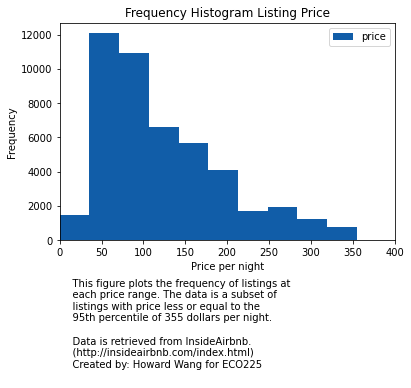

In [ ]:
txt = '''
    This figure plots the frequency of listings at
    each price range. The data is a subset of
    listings with price less or equal to the
    95th percentile of 355 dollars per night.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225
    '''


data_95th[['price']].plot(kind='hist',color="#115DA8")
plt.title("Frequency Histogram Listing Price")
plt.xlabel("Price per night")
plt.xlim(0, 400)
plt.text(0.1,-8100, txt)

We can see that there is the largest number from listings between the 50 to 100 dollar range. Also note that there is a decreasing number of listings as price increases. This suggets that hosts understand consumers are price sensitive.

Text(0.1, -0.27, '\n    This figure shows the total number of AirBnb listings\n    by room type in NYC.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225\n    ')

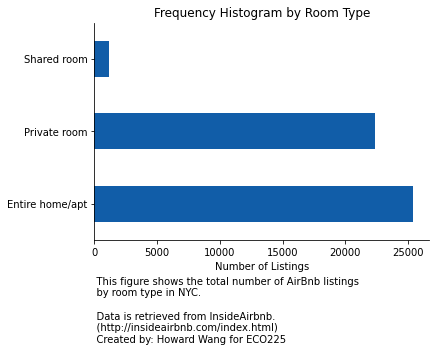

In [ ]:

txt = '''
    This figure shows the total number of AirBnb listings
    by room type in NYC.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225
    '''

fig, ax = plt.subplots()
data['room_type'].value_counts().plot(kind='barh', ax=ax, color="#115DA8")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Frequency Histogram by Room Type")

ax.set_xlabel("Number of Listings")
#plt.grid(axis='x')

fig.text(0.1,-0.27,txt)

From the histogram above, we note that most listings in New York City are for the entire home/apartment. The second most popular listed room type are private rooms and the least popular, by far, are shared rooms. This suggests that many hosts understand the value of privacy for customers.

Text(0.1, -0.27, '\n    This figure shows the total number of AirBnb listings\n    in the Boroughs of NYC.\n    \n    Data is retrieved from InsideAirbnb.\n    (http://insideairbnb.com/index.html)\n    Created by: Howard Wang for ECO225\n    ')

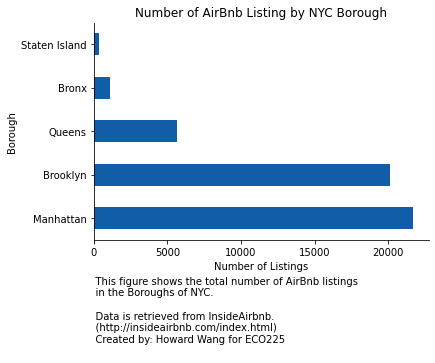

In [ ]:

txt = '''
    This figure shows the total number of AirBnb listings
    in the Boroughs of NYC.
    
    Data is retrieved from InsideAirbnb.
    (http://insideairbnb.com/index.html)
    Created by: Howard Wang for ECO225
    '''

fig, ax = plt.subplots()
data['neighbourhood_group'].value_counts().plot(kind='barh', ax=ax, color="#115DA8")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Number of AirBnb Listing by NYC Borough")

ax.set_xlabel("Number of Listings")
ax.set_ylabel("Borough")
#plt.grid(axis='x')


fig.text(0.1,-0.27,txt)

From the histogram above, we can see the number of listings in each neighbourhood in New York City. In descending order; Manhattan, Brooklyn, Queens, Bronx and Staten Island. The majority of listings are found in either Manhattan and Brooklyn, this may suggest that Manhattan and Brooklyn have high population which leads to the high demand for AirBnbs. We will be exploring this later in the project.

### Visualizing Price to Room Type and Price to Neighbourhood

Text(0.5, 0.98, '')

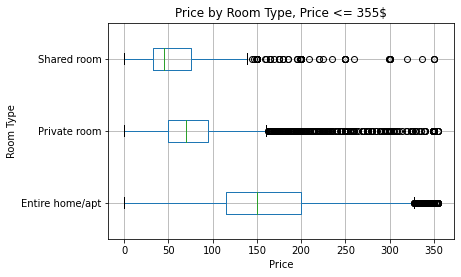

In [ ]:
# Since room_type is a categorical data, lets creates a boxplot to take a look
# at how price differs by room_type

data_95th.boxplot(column = 'price', by = "room_type", vert=False)
plt.xlabel("Price")
plt.ylabel("Room Type")
plt.title("Price by Room Type, Price <= 355$")
plt.suptitle("")

In the plot above, we can see how price differs by room type. There seems to be a larger variation in prices for listings of the entire home/apartment and private room type compared to shared rooms. The median listing price for entire home/apartment are higher compared to private rooms. Private rooms in turn have a higher median listing price compared to shared rooms. This make sense as we expect consumers are willing to pay more for more privacy and a larger space. We note that shared rooms have the median of around 40 dollars per night, private rooms at around 70 dollars per night and entire home/apartments at around 150 dollars per night.

We are using a filtered data set to remove the outliers by filtering the data for price to less than 355 dollars per night, which is the 95th percentile. The plots would be very zoomed out otherwise.

Text(0.5, 0.98, '')

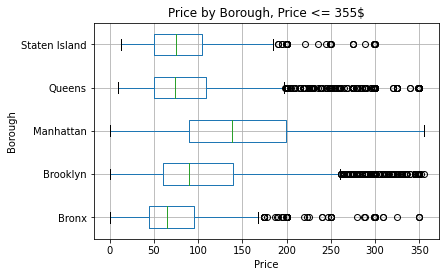

In [ ]:
data_95th.boxplot(column = 'price', by = "neighbourhood_group", vert=False)
plt.xlabel("Price")
plt.ylabel("Borough")
plt.title("Price by Borough, Price <= 355$")
plt.suptitle("")

In the plot above, we can see how price differs between the boroughs of New York City. Although the majority of listings are similar across Staten Island, Queens, Brooklyn and Bronx, Manhattan stands out with the only median price above 100 dollars per night. Manhattan has the widest IQR range meaning Manhattan has the largest variation of prices between all five boroughs. Brooklyn trailed with the second highest median price. Staten Island and Queens had similar median prices but Queens had more variations in prices and more outliers. Finally, Bronx had the lowest median listing price and a small IQR range, suggesting that Airbnbs in Bronx are generally cheaper compared to another borough in NYC. 

We are using a filtered data set to remove the outliers by filtering the data for price to less than 355 dollars per night, which is the 95th percentile. The plots would be very zoomed out otherwise.

## Part 2 Question and Message

The Question: How does the room type and location of an Airbnb listing affect its listing price?

The Message: So far, we've seen how the room type of the listing affects it's prices. Generally, entire homes/apartments have a higher lising price compared to private rooms which is followed by shared rooms. We've also seen that generally, Manhattan listings are the most expensive followed by Brooklyn. Staten Island and Queens have similar median prices and the Bronx has the lowest.

In part 3 we will create maps that of NYC that illustrate how price differs in NYC in general. We will also group listings by room type and create separate maps for each.

## Part 3 Maps

In [ ]:
# read in county shape data
county_df = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip")
county_df.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."


In [ ]:
# create a geometry column used as that applies Point function to longitude and latitude
data["geometry"] = list(zip(data.longitude, data.latitude))
data["geometry"] = data["geometry"].apply(Point)

# create a geodataframe from our pandas dataframe
gdf = gpd.GeoDataFrame(data, crs= 4326, geometry="geometry")

gdf.head(2)

,id,price,room_type,neighbourhood_group,neighbourhood,latitude,longitude,geometry
0,2539,149,Private room,Brooklyn,Kensington,40.64749,-73.97237,POINT (-73.97237 40.64749)
1,2595,225,Entire home/apt,Manhattan,Midtown,40.75362,-73.98377,POINT (-73.98377 40.75362)


In [ ]:
# Filtered by GEOID for the 5 boughs of NYC
county_df = county_df.query("GEOID in ['36005', '36047', '36061', '36081', '36085']")

# made naming changes to match county data with airbnb data
county_df["NAME"].replace({
    "Kings": "Brooklyn",
    "New York": "Manhattan",
    "Richmond": "Staten Island"}, inplace = True)

county_df

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1399,36,085,00974141,36085,Staten Island,Richmond County,06,H6,G4020,408,35620,35614,C,148976885,115948458,+40.5612628,-074.1398995,"POLYGON ((-74.25909 40.49956, -74.25909 40.499..."
2333,36,081,00974139,36081,Queens,Queens County,06,H6,G4020,408,35620,35614,C,281734463,179364919,+40.6585662,-073.8380168,"POLYGON ((-74.03813 40.53829, -74.03749 40.542..."
2409,36,047,00974122,36047,Brooklyn,Kings County,06,H6,G4020,408,35620,35614,C,179671310,71098973,+40.6350451,-073.9506398,"POLYGON ((-74.05647 40.63171, -74.05626 40.637..."
2446,36,061,00974129,36061,Manhattan,New York County,06,H6,G4020,408,35620,35614,C,58690498,28541727,+40.7766419,-073.9701871,"MULTIPOLYGON (((-74.03294 40.68778, -74.02628 ..."
3162,36,005,00974101,36005,Bronx,Bronx County,06,H6,G4020,408,35620,35614,C,108909571,39687923,+40.8487111,-073.8529390,"POLYGON ((-73.93365 40.88246, -73.93173 40.885..."


Text(0.5, 109.01504300107274, 'Longtitude')

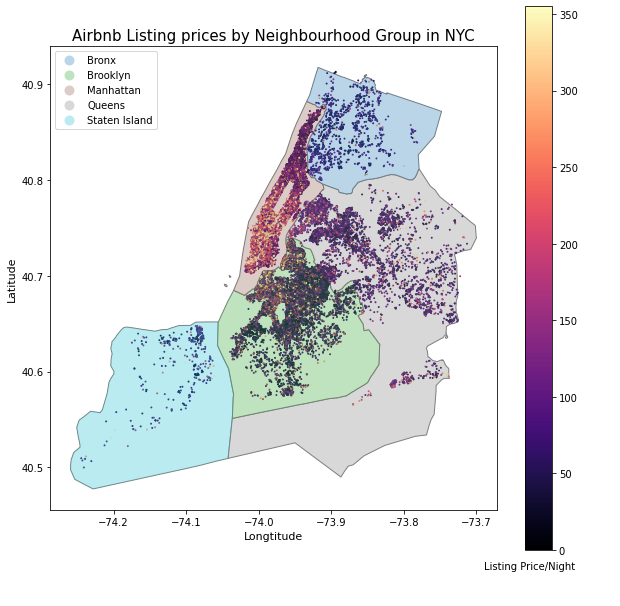

In [ ]:
# Plot listings and prices on map
fig, gax = plt.subplots(figsize=(10, 10))
county_df.plot(ax=gax, edgecolor = 'grey', color='white')
gdf.plot(ax=gax, column = 'price',  vmin=0, vmax=355, markersize = .9, legend = True, cmap='magma')

county_df.plot(column = "NAME", legend = True, alpha = 0.3, ax = gax)
gax.set_title("Airbnb Listing prices by Neighbourhood Group in NYC", fontsize = 15)

gax.annotate('Listing Price/Night',xy=(0.78, 0.06),  xycoords='figure fraction')

gax.set_ylabel("Latitude", fontsize = 11)
gax.set_xlabel("Longtitude", fontsize = 11)

We can see from the plot above that listings in Brooklyn and Manhattan had a wide range of prices. Airbnbs' with a low and high listings prices were found in Manhattan and Brooklyn, while Bronx, Staten Island and Queens mainly had cheaper listings. South Manhattan stands out with the most number of listings with high listing prices. North Brooklyn also had a number of high priced Airbnbs, suggesting that the demand for Airbnbs in North Brooklyn and South Manhattan are high. 

Text(0.92, 0.76, 'Listing Price/Night')

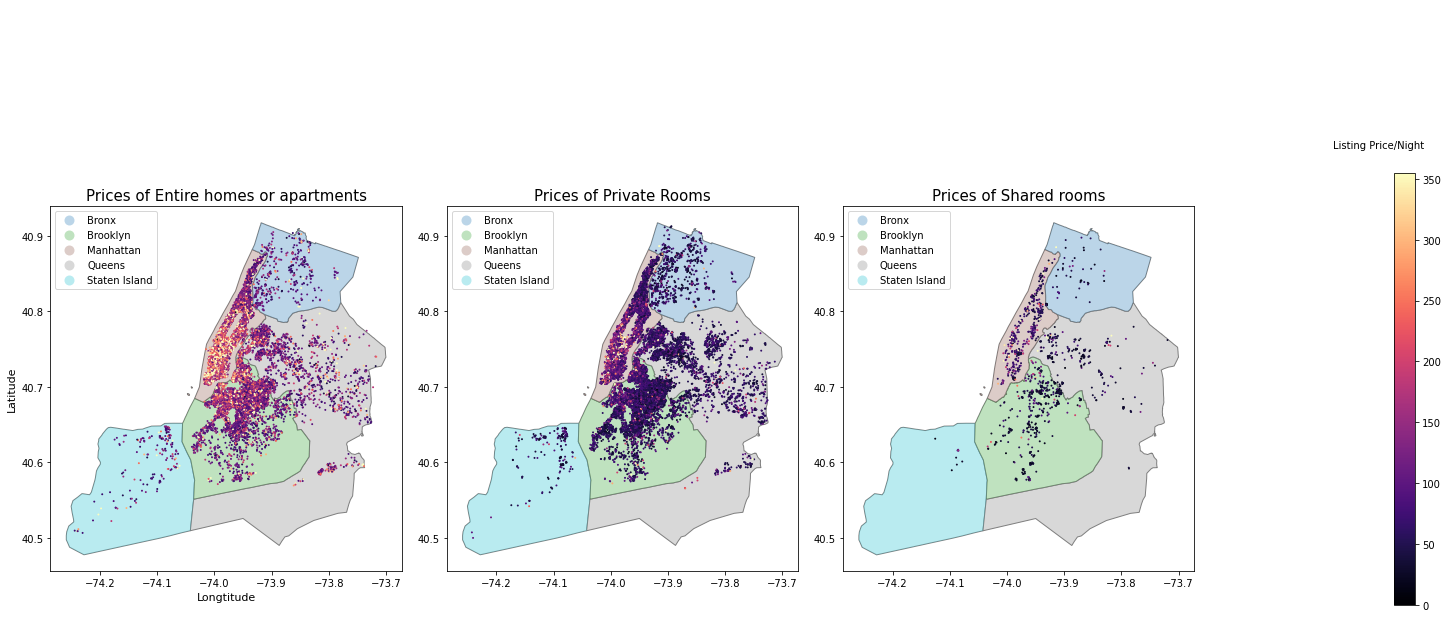

In [ ]:
# Now lets take a look at how the average listing price looks
fig, gax = plt.subplots(1, 3, figsize=(20,20), constrained_layout=True)

for ax in gax.reshape(-1):
  county_df.plot(ax = ax, edgecolor = "grey", color = "white")
  county_df.plot(column = "NAME", legend = True, alpha = .3, ax = ax)

# filter and map entire hooms/apt
ent_room = gdf.query("room_type == 'Entire home/apt'")
ent_room.plot(ax=gax[0], column = 'price',  vmin=0, vmax=355, markersize = .9, cmap='magma')

# filter and map entire private
pri_room = gdf.query("room_type == 'Private room'")
pri_room.plot(ax=gax[1], column = 'price',  vmin=0, vmax=355, markersize = .9, cmap='magma')

# filter and map entire shared room
shared_room = gdf.query("room_type == 'Shared room'")
shared_room.plot(ax=gax[2], column = 'price',  vmin=0, vmax=355, markersize = .9, cmap='magma')

# Add a color bar to the far left graph
norm_95th = Normalize(vmin=0, vmax=355, clip=True)
col_bar = cm.ScalarMappable(norm=norm_95th, cmap='magma')
fig.colorbar(col_bar, ax = gax[2], location="right", shrink = 0.3)

# add titles
gax[0].set_title("Prices of Entire homes or apartments", fontsize = 15)
gax[1].set_title("Prices of Private Rooms", fontsize = 15)
gax[2].set_title("Prices of Shared rooms", fontsize = 15)

# add axis 
gax[0].set_ylabel("Latitude", fontsize = 11)
gax[0].set_xlabel("Longtitude", fontsize = 11)

gax[2].annotate('Listing Price/Night',xy=(0.92, 0.76),  xycoords='figure fraction')



The figure above confirms that the majority of listings were for entire homes and apartments followed by private rooms and finally shared rooms were the least popular listings. Listings of the entire homes or apartments were mainly listed for higher prices. Although there were private rooms and shared rooms with high listings prices, the majority of listings were for the lower end of prices. This does not come as a surprise as we think people value privacy and are willing to pay more for it.

### Bonus Interactive Map

In [ ]:
# getting the mean listing price by neighbourhood 
mean_neighbourhood = gdf.groupby('neighbourhood_group').mean()
mean_neighbourhood.reset_index(inplace=True)
mean_neighbourhood = mean_neighbourhood[['neighbourhood_group',"price"]]
mean_neighbourhood.rename(columns={'price': 'average_neighbourhood_price'}, inplace=True)

#rename column and join to add as a column in county_df
county_df.rename(columns={'NAME' : 'neighbourhood_group'}, inplace=True)
county_df = county_df.merge(mean_neighbourhood, how='left', on = 'neighbourhood_group')

# print our average prices
print(county_df['average_neighbourhood_price'])

# print out mean price
print(np.mean(county_df['average_neighbourhood_price']))


0    114.812332
1     99.517649
2    124.383207
3    196.875814
4     87.496792
Name: average_neighbourhood_price, dtype: float64
124.61715890102955


In [ ]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource, save
from bokeh.io import output_notebook, show, output_file
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer

from bokeh.resources import INLINE
output_notebook(INLINE)
import json

In [ ]:
#Convert data to geojson for bokeh
county_geojson=GeoJSONDataSource(geojson=county_df.to_json())

In [ ]:
color_mapper = LinearColorMapper(palette = 'Magma256', low =80 , high = 200)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [('Borough','@neighbourhood_group'),('Average Price', '@average_neighbourhood_price')])

p = figure(title="Average Listings Prices by NYC Borough", tools=[hover])
p.patches("xs","ys",source=county_geojson,
          fill_color = {'field' :'average_neighbourhood_price', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
#output_file('prj2_Interactive_fig_hwang.html', mode='inline')
show(p)

**PLEASE USE THE LINK BELOW**
The link below is to a github repository which hosts the HTML to the interactive figure. Please download the HTML file to access figure.

https://github.com/hwang-UofT/eco225_pro2

### Bonus - Additional Data Set

Let's now pull a dataset containing population estimates for the Boroughs of NYC on July 1, 2019.

We will clean the data and then merge in data with our county data set which includes the unique borough names and geometry data.

We would be able to calculate the population density of each NYC borough and map the results to see the relationship between population density and Airbnb listing price.

This data set is retrived from the United States Census Bureau.
https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219

In [ ]:
population_df = pd.read_csv("QuickFacts Mar-04-2021.csv")
population_df.head()

,Fact,Fact Note,"New York city, New York","Value Note for New York city, New York","Bronx County (Bronx Borough), New York","Value Note for Bronx County (Bronx Borough), New York","Kings County (Brooklyn Borough), New York","Value Note for Kings County (Brooklyn Borough), New York","New York County (Manhattan Borough), New York","Value Note for New York County (Manhattan Borough), New York","Queens County (Queens Borough), New York","Value Note for Queens County (Queens Borough), New York","Richmond County (Staten Island Borough), New York","Value Note for Richmond County (Staten Island Borough), New York"
0,"Population estimates, July 1, 2019, (V2019)",NaN,"8,336,817",NaN,"1,418,207",NaN,"2,559,903",NaN,"1,628,706",NaN,"2,253,858",NaN,"476,143",NaN
1,"Population estimates base, April 1, 2010, (V2...",NaN,"8,175,031",NaN,"1,384,580",NaN,"2,504,721",NaN,"1,586,381",NaN,"2,230,619",NaN,"468,730",NaN
2,"Population, percent change - April 1, 2010 (es...",NaN,2.0%,NaN,2.4%,NaN,2.2%,NaN,2.7%,NaN,1.0%,NaN,1.6%,NaN
3,"Population, Census, April 1, 2010",NaN,"8,175,133",NaN,"1,385,108",NaN,"2,504,700",NaN,"1,585,873",NaN,"2,230,722",NaN,"468,730",NaN
4,"Persons under 5 years, percent",NaN,6.5%,NaN,7.1%,NaN,7.1%,NaN,4.7%,NaN,6.1%,NaN,5.7%,NaN


In [ ]:
# isolate first row
population_df = population_df.iloc[[0]]
population_df = population_df.T.reset_index()
# rename columns
population_df = population_df.rename(columns={"index":"neighbourhood_group", 0:'population_2019'})

#drop NAs
population_df.dropna(inplace=True)

# drop rows we dont need
population_df.drop([0,2], inplace=True)
population_df

,neighbourhood_group,population_2019
4,"Bronx County (Bronx Borough), New York","1,418,207"
6,"Kings County (Brooklyn Borough), New York","2,559,903"
8,"New York County (Manhattan Borough), New York","1,628,706"
10,"Queens County (Queens Borough), New York","2,253,858"
12,"Richmond County (Staten Island Borough), New York","476,143"


In [ ]:
# made naming changes to match county data with airbnb data
population_df["neighbourhood_group"].replace({
    "Bronx County (Bronx Borough), New York": "Bronx",
    "Kings County (Brooklyn Borough), New York": "Brooklyn",
    "New York County (Manhattan Borough), New York": "Manhattan",
    "Queens County (Queens Borough), New York": "Queens",
    "Richmond County (Staten Island Borough), New York": "Staten Island"}, inplace = True)
population_df


,neighbourhood_group,population_2019
4,Bronx,"1,418,207"
6,Brooklyn,"2,559,903"
8,Manhattan,"1,628,706"
10,Queens,"2,253,858"
12,Staten Island,"476,143"


In [ ]:
# Merge with airbnb dataset

# add population column
merged_county = county_df.merge(population_df, how='left', left_on="NAME", right_on="neighbourhood_group")

# add area column
merged_county["Area"] = merged_county.geometry.area

merged_county["population_2019"] = merged_county["population_2019"].str.replace(',', '').astype(float)
merged_county["Pop_Density"] = merged_county["population_2019"]/merged_county["Area"]

merged_county.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,neighbourhood_group,population_2019,Area,Pop_Density
0,36,085,00974141,36085,Staten Island,Richmond County,06,H6,G4020,408,35620,35614,C,148976885,115948458,+40.5612628,-074.1398995,"POLYGON ((-74.25909 40.49956, -74.25909 40.499...",Staten Island,476143.0,0.028171,1.690216e+07
1,36,081,00974139,36081,Queens,Queens County,06,H6,G4020,408,35620,35614,C,281734463,179364919,+40.6585662,-073.8380168,"POLYGON ((-74.03813 40.53829, -74.03749 40.542...",Queens,2253858.0,0.049100,4.590380e+07
2,36,047,00974122,36047,Brooklyn,Kings County,06,H6,G4020,408,35620,35614,C,179671310,71098973,+40.6350451,-073.9506398,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",Brooklyn,2559903.0,0.026694,9.589906e+07
3,36,061,00974129,36061,Manhattan,New York County,06,H6,G4020,408,35620,35614,C,58690498,28541727,+40.7766419,-073.9701871,"MULTIPOLYGON (((-74.03294 40.68778, -74.02628 ...",Manhattan,1628706.0,0.009305,1.750397e+08
4,36,005,00974101,36005,Bronx,Bronx County,06,H6,G4020,408,35620,35614,C,108909571,39687923,+40.8487111,-073.8529390,"POLYGON ((-73.93365 40.88246, -73.93173 40.885...",Bronx,1418207.0,0.015868,8.937484e+07


Text(0.5, 155.34715325001977, 'Longtitude')

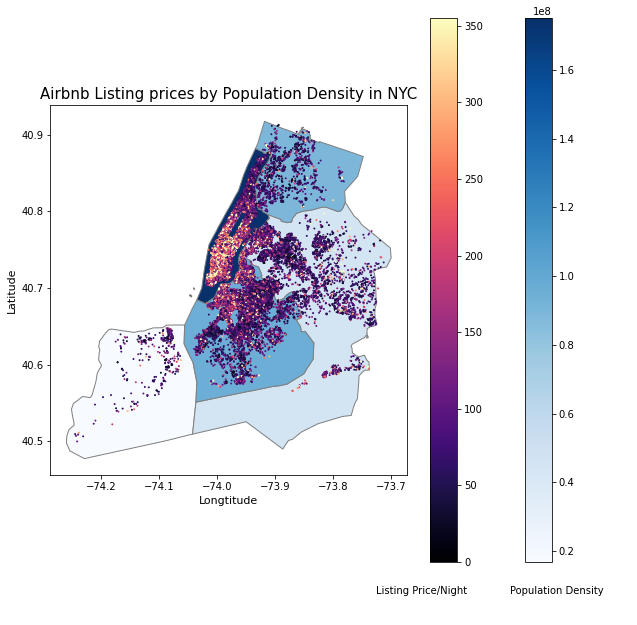

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))
merged_county.plot(ax = gax, column="Pop_Density", cmap="Blues", edgecolor = 'grey', legend=True)

gdf.plot(ax=gax, column = 'price',  vmin=0, vmax=355, markersize = .9, legend = True, cmap='magma')

gax.set_title("Airbnb Listing prices by Population Density in NYC", fontsize = 15)

gax.annotate('Listing Price/Night',xy=(0.59, 0.05),  xycoords='figure fraction')
gax.annotate('Population Density',xy=(0.8, 0.05),  xycoords='figure fraction')

gax.set_ylabel("Latitude", fontsize = 11)
gax.set_xlabel("Longtitude", fontsize = 11)


We can see that Manhattan and Brooklyn are the highest population desentiy levels and have a number of high priced airbnb listings. Similarily, Bronx has the lowest population density and generally lower price. This aligns with our preivous findings that Bronx had the lowest median price and Manhattan had the highest. This suggests that Population density might have a positive relationship with Airbnb price listings. The high population density suggests that there are more demand for places to sleep / live in compared to low population density places. This naturally means, a higher demand for housing and a higher price as we see in the data.

### Conclusion and Future Steps

In the second project, I made changes based on the comments I receieved in project 1. I fine tuned my graphs and updated my anaylses on my visualizations.
I created visualizations that illustrate how price differs between entire homes/apartments, private rooms and shared rooms on a map of NYC. I also made a map on NYC containing all listings in each of the boroughs. We discovered that the median listing price and the variation in listing price was highest in listings for entire homes/apartments. Median and variation in listing price decreased in private rooms and was the lowest in shared rooms. We discovered that Manhattan had both the highest and largest variation in listing prices. Brooklyn had the second highest median listing price while Queens and Staten Island had similar median prices and Bronx had the lowest. South Manhattan stands out with the most number of listings with high listing prices. North Brooklyn also had a number of high priced Airbnbs suggesting that the demand for Airbnbs in North Brooklyn and South Manhattan are high. 

I also combined a NYC borough population estimate data to calculate the population density of the boroughs. I created a map that illustrated higher population density boroughs generally had higher listing prices. 




---
Future Steps

In the future I would want to look into fitting a linear model that predicts the price provided a Airbnb's listing and room type. I would want to analyze my model to reach a conclusion for my research question of what is the effect a Airbnb listing's room type and neighbourhood has on its price. I would do this by testing the significance of my coefficient estimates for predicting listing price.